<a href="https://colab.research.google.com/github/Funmatu/topological-physical-router/blob/main/Unified_Topological_and_Physical_Routing_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking 24 permutation patterns...

          INTEGRATED ANALYSIS REPORT

[A] Mathematical Topology (Graph Theory & Algebra)
  1. Graph Planarity (Is Solvable?): True
     -> Solvable (No Topological Obstacle)
  2. Geometric Intersections (Straight lines): 0
  3. Topological Invariant (Crossing Number): 2
     -> Boundary Status: LOCKED (Entangled)
--------------------------------------------------
  Matrix of Intersections (Algebraic Structure):
[[0 0 0 0]
 [0 0 1 1]
 [0 1 0 0]
 [0 1 0 0]]
--------------------------------------------------

[B] Physical Reality (Engineering Simulation)
  Best Order: ['red', 'blue', 'green', 'orange']
  Physically Solvable: True



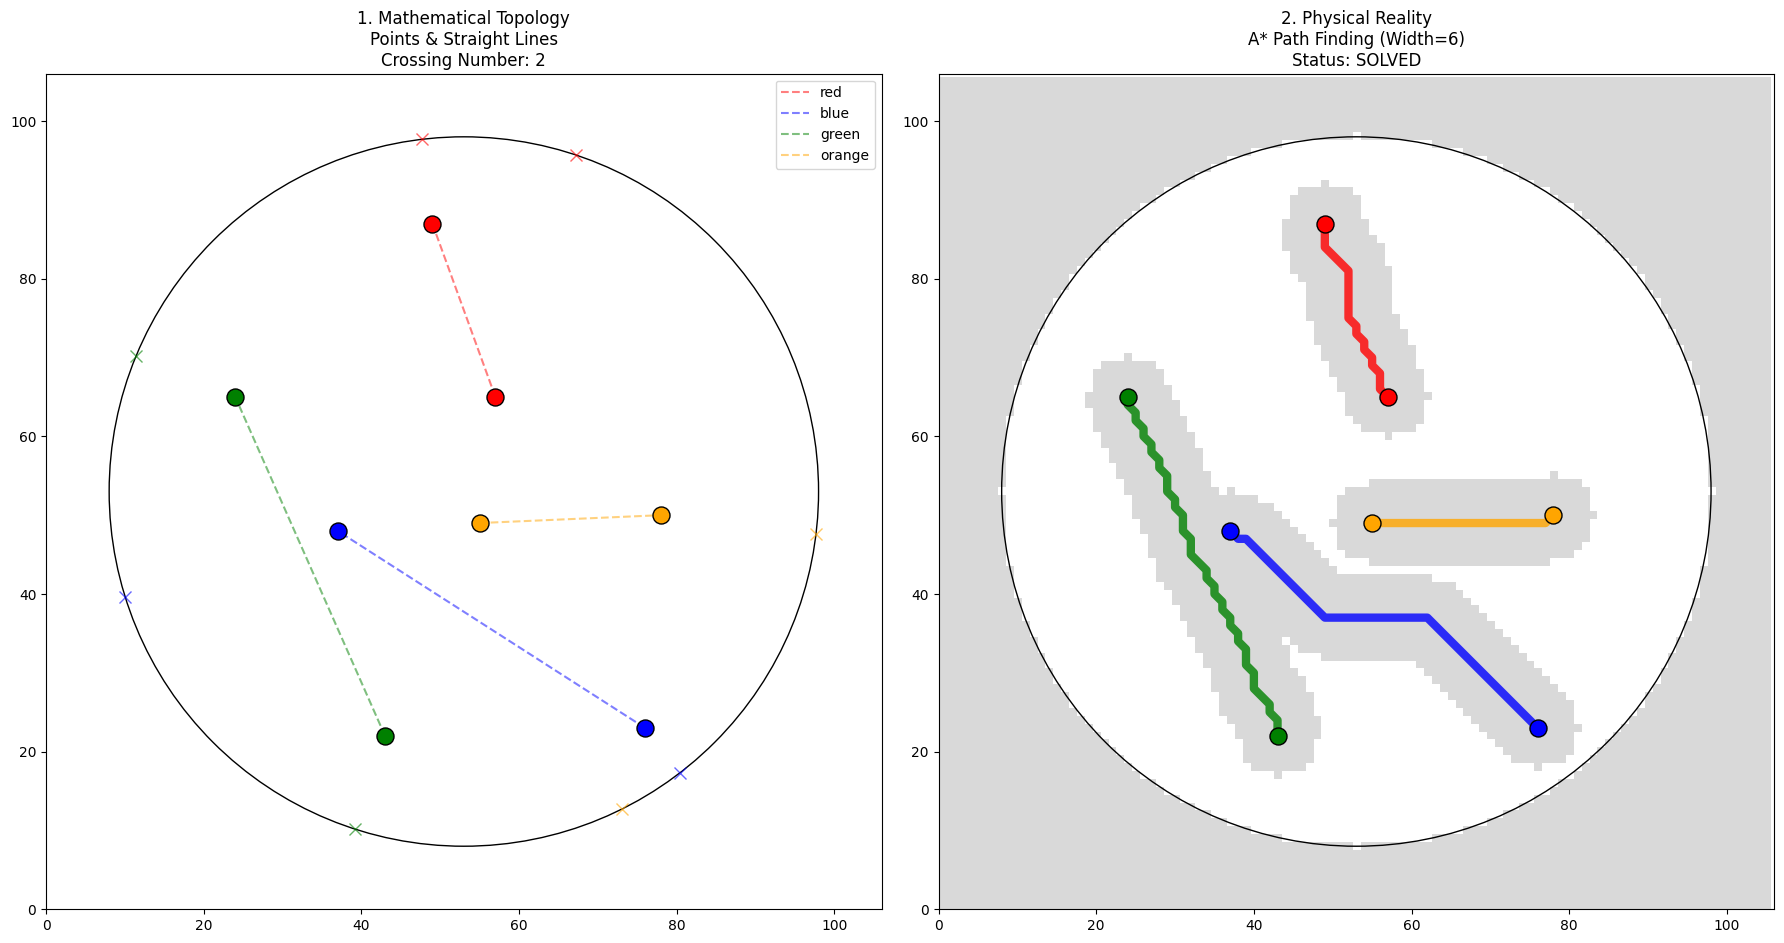

In [14]:
"""
Project: Unified Topological & Physical Routing Simulator
Description:
    このプログラムは、閉じた円平面内における点対接続問題を、
    数学的（グラフ理論・トポロジー）および工学的（物理制約・探索）な視点から
    包括的に解析・可視化するための学習用基盤です。

    【機能】
    1. Mathematical Topology (Theoretical):
       - グラフ理論: 平面グラフ判定（NetworkX）
       - 代数的位相幾何: 点を円周上に射影した際の「交差行列」と「交差数（不変量）」の導出
       - 幾何学: 直線で結んだ場合の単純交差判定

    2. Physical Reality (Engineering):
       - マルチエージェント経路探索: 線の「太さ」を考慮したA*アルゴリズム
       - 順列全探索: 配線順序の最適化によるデッドロック回避

"""

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import heapq
import itertools
from typing import List, Tuple, Dict, Optional, Any

# 型エイリアス
GridMap = np.ndarray
Path = List[Tuple[int, int]]

class IntegratedRouter:
    """
    数学的抽象と物理的現実を統合して検証するルータークラス。

    Attributes:
        radius (int): 円の半径。
        line_width (int): 物理配線の太さ。
        clearance (int): 安全間隔。
        grid_size (int): グリッドサイズ。
        pairs_data (List[Dict]): ペア情報のリスト。
    """

    def __init__(self, radius: int = 45, line_width: int = 6, clearance: int = 2):
        """
        Args:
            radius (int): シミュレーション半径。
            line_width (int): 線の太さ（物理制約）。
            clearance (int): オブジェクト間の隙間。
        """
        self.radius = radius
        self.grid_size = radius * 2 + 16
        self.center = (self.grid_size // 2, self.grid_size // 2)

        self.line_width = line_width
        self.clearance = clearance

        self.pairs_data: List[Dict[str, Any]] = []
        self.base_obstacles: GridMap = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self._init_boundary_walls()

    def _init_boundary_walls(self) -> None:
        """物理シミュレーション用の外周壁を作成"""
        y, x = np.ogrid[:self.grid_size, :self.grid_size]
        dist_from_center = np.sqrt((x - self.center[0])**2 + (y - self.center[1])**2)
        self.base_obstacles[dist_from_center > self.radius] = 1

    def generate_scenario(self, num_pairs: int = 4, boundary_constraint: bool = False) -> None:
        """
        シナリオ生成。

        Args:
            num_pairs (int): ペア数。
            boundary_constraint (bool): Trueの場合、点を強制的に円周付近に配置する。
                                      これによりトポロジー的な「絡まり」が発生しやすくなる。
        """
        self.pairs_data = []
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        existing_points = []
        min_dist = self.line_width * 2 + self.clearance

        for i in range(num_pairs):
            pair_points = []
            for _ in range(2):
                attempts = 0
                while attempts < 200:
                    # 境界制約の適用
                    if boundary_constraint:
                        # 円周付近 (r ~ radius)
                        r = self.radius - 2
                    else:
                        # 内部ランダム (面積均一)
                        r = (self.radius - 5) * np.sqrt(np.random.random())

                    theta = np.random.random() * 2 * np.pi
                    x = int(self.center[0] + r * np.cos(theta))
                    y = int(self.center[1] + r * np.sin(theta))

                    # 衝突チェック
                    valid = True
                    for ep in existing_points:
                        if np.sqrt((x - ep[0])**2 + (y - ep[1])**2) < min_dist:
                            valid = False
                            break
                    if valid:
                        pair_points.append((x, y))
                        existing_points.append((x, y))
                        break
                    attempts += 1

            if len(pair_points) == 2:
                self.pairs_data.append({
                    'id': i,
                    'start': pair_points[0],
                    'end': pair_points[1],
                    'color': colors[i % len(colors)]
                })

    # =========================================================================
    # 1. Mathematical & Topological Analysis
    # =========================================================================

    def check_graph_planarity(self) -> bool:
        """
        グラフ理論的判定: 平面グラフとして描画可能か？
        外周サイクルを考慮した埋め込み判定を行う。
        """
        G = nx.Graph()
        # 外周ノードによる閉路を追加（境界条件のシミュレーション）
        boundary_nodes = [f"boundary_{i}" for i in range(4)]
        nx.add_cycle(G, boundary_nodes)

        for p in self.pairs_data:
            G.add_edge(f"s_{p['id']}", f"e_{p['id']}")

        return nx.check_planarity(G)[0]

    def check_geometric_intersection(self) -> int:
        """
        幾何学的判定: 単純な直線で結んだ場合の交差数。
        """
        def ccw(A, B, C):
            return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])
        def intersect(A, B, C, D):
            return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

        count = 0
        n = len(self.pairs_data)
        for i in range(n):
            for j in range(i + 1, n):
                p1 = self.pairs_data[i]['start']
                p2 = self.pairs_data[i]['end']
                p3 = self.pairs_data[j]['start']
                p4 = self.pairs_data[j]['end']
                if intersect(p1, p2, p3, p4):
                    count += 1
        return count

    def analyze_algebraic_topology(self) -> Dict[str, Any]:
        """
        代数位相幾何学的判定:
        点を円周上に射影(Projection)したと仮定し、交差行列と交差数(Crossing Number)を算出する。
        これにより「本質的な絡まり」を判定する。
        """
        # 1. 全点の角度を計算し、円周上の順序リストを作成
        projections = []
        cx, cy = self.center
        for p in self.pairs_data:
            # Start Point
            theta_s = np.arctan2(p['start'][1] - cy, p['start'][0] - cx)
            projections.append({'id': p['id'], 'theta': theta_s})
            # End Point
            theta_e = np.arctan2(p['end'][1] - cy, p['end'][0] - cx)
            projections.append({'id': p['id'], 'theta': theta_e})

        # 角度順にソート (-pi to pi)
        projections.sort(key=lambda x: x['theta'])

        # 順序列 (例: [0, 1, 0, 1])
        order_sequence = [item['id'] for item in projections]

        # 2. 交差行列 (Intersection Matrix) の作成
        n = len(self.pairs_data)
        matrix = np.zeros((n, n), dtype=int)

        # 弦iと弦jが交差 <==> 端点が交互(interleave)に出現する
        for i in range(n):
            for j in range(i + 1, n):
                indices_i = [x for x, val in enumerate(order_sequence) if val == i]
                indices_j = [x for x, val in enumerate(order_sequence) if val == j]

                # 始点・終点が正しく取得できているか確認
                if len(indices_i) != 2 or len(indices_j) != 2: continue

                s_i, e_i = indices_i
                s_j, e_j = indices_j

                # インターリーブ判定: s_i < s_j < e_i < e_j OR s_j < s_i < e_j < e_i
                if (s_i < s_j < e_i < e_j) or (s_j < s_i < e_j < e_i):
                    matrix[i][j] = matrix[j][i] = 1

        crossing_number = int(np.sum(matrix) / 2)

        return {
            "matrix": matrix,
            "crossing_number": crossing_number,
            "is_locked": crossing_number > 0
        }

    # =========================================================================
    # 2. Physical Simulation (A* with Width)
    # =========================================================================

    def solve_physical_permutations(self) -> Dict[str, Any]:
        """順列全探索による物理シミュレーション"""
        all_orders = list(itertools.permutations(self.pairs_data))
        best_success = None
        best_failure = None
        min_cost = float('inf')
        max_conn = -1

        print(f"Checking {len(all_orders)} permutation patterns...")

        for ordered_pairs in all_orders:
            success, paths, count, cost, grid = self._run_simulation(ordered_pairs)

            res = {
                'success': success,
                'indices': [p['id'] for p in ordered_pairs],
                'colors': [p['color'] for p in ordered_pairs],
                'paths': paths,
                'grid': grid,
                'cost': cost,
                'count': count
            }

            if success:
                if cost < min_cost:
                    min_cost = cost
                    best_success = res

            if count > max_conn:
                max_conn = count
                best_failure = res
            elif count == max_conn and best_failure:
                if cost < best_failure['cost']:
                    best_failure = res

        return best_success if best_success else best_failure

    def _run_simulation(self, ordered_pairs):
        grid = self.base_obstacles.copy()
        # 一旦全点を障害物化
        for p in self.pairs_data:
            self._mark_spot(grid, p['start'], self.line_width // 2)
            self._mark_spot(grid, p['end'], self.line_width // 2)

        paths = {}
        total_cost = 0
        connected = 0

        for p in ordered_pairs:
            # 自分の足元をクリア
            temp_grid = grid.copy()
            self._clear_spot(temp_grid, p['start'], self.line_width // 2 + 1)
            self._clear_spot(temp_grid, p['end'], self.line_width // 2 + 1)

            path = self._astar(p['start'], p['end'], temp_grid)

            if path:
                paths[p['id']] = path
                total_cost += len(path)
                connected += 1
                # 経路を新たな壁として登録
                for pt in path:
                    self._mark_spot(grid, pt, self.line_width // 2 + self.clearance)
            else:
                paths[p['id']] = None

        return (connected == len(ordered_pairs)), paths, connected, total_cost, grid

    def _mark_spot(self, grid, pt, r):
        y, x = np.ogrid[:self.grid_size, :self.grid_size]
        mask = (x - pt[0])**2 + (y - pt[1])**2 <= r**2
        grid[mask] = 1

    def _clear_spot(self, grid, pt, r):
        y, x = np.ogrid[:self.grid_size, :self.grid_size]
        mask = (x - pt[0])**2 + (y - pt[1])**2 <= r**2
        grid[mask] = 0

    def _astar(self, start, end, grid):
        if grid[start[1]][start[0]] == 1 or grid[end[1]][end[0]] == 1: return None

        neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
        close_set = set()
        came_from = {}
        g_score = {start: 0}
        f_score = {start: self._heuristic(start, end)}
        oheap = []
        heapq.heappush(oheap, (f_score[start], start))

        while oheap:
            current = heapq.heappop(oheap)[1]
            if current == end:
                data = []
                while current in came_from:
                    data.append(current)
                    current = came_from[current]
                data.append(start)
                return data[::-1]

            close_set.add(current)
            for i, j in neighbors:
                nx, ny = current[0]+i, current[1]+j
                neighbor = (nx, ny)
                if not (0 <= nx < self.grid_size and 0 <= ny < self.grid_size): continue
                if grid[ny][nx] == 1: continue
                if neighbor in close_set: continue

                tentative_g_score = g_score[current] + np.sqrt(i**2+j**2)
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self._heuristic(neighbor, end)
                    heapq.heappush(oheap, (f_score[neighbor], neighbor))
        return None

    def _heuristic(self, a, b):
        return np.sqrt((b[0]-a[0])**2 + (b[1]-a[1])**2)

    # =========================================================================
    # 3. Visualization & Reporting
    # =========================================================================

    def execute_and_report(self):
        # 解析実行
        topo_data = self.analyze_algebraic_topology()
        is_planar = self.check_graph_planarity()
        geo_cross = self.check_geometric_intersection()
        phys_res = self.solve_physical_permutations()

        # --- テキストレポート ---
        print("\n" + "="*60)
        print("          INTEGRATED ANALYSIS REPORT")
        print("="*60)

        print(f"\n[A] Mathematical Topology (Graph Theory & Algebra)")
        print(f"  1. Graph Planarity (Is Solvable?): {is_planar}")
        print(f"     -> {'Solvable (No Topological Obstacle)' if is_planar else 'Unsolvable (Topologically Locked)'}")
        print(f"  2. Geometric Intersections (Straight lines): {geo_cross}")
        print(f"  3. Topological Invariant (Crossing Number): {topo_data['crossing_number']}")
        print(f"     -> Boundary Status: {'LOCKED (Entangled)' if topo_data['is_locked'] else 'FREE (Trivial)'}")

        print("-" * 50)
        print("  Matrix of Intersections (Algebraic Structure):")
        print(topo_data['matrix'])
        print("-" * 50)

        print(f"\n[B] Physical Reality (Engineering Simulation)")
        print(f"  Best Order: {phys_res['colors']}")
        print(f"  Physically Solvable: {phys_res['success']}")
        if not phys_res['success']:
             print("  -> Failure Reason: Line width/clearance constraints caused blocking.")

        print("="*60 + "\n")

        # --- 可視化 ---
        self.visualize(topo_data, phys_res)

    def visualize(self, topo_data, phys_res):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

        # 左：数学的トポロジー視点
        circle1 = plt.Circle(self.center, self.radius, color='black', fill=False)
        ax1.add_patch(circle1)
        ax1.set_title(f"1. Mathematical Topology\nPoints & Straight Lines\nCrossing Number: {topo_data['crossing_number']}")
        ax1.set_xlim(0, self.grid_size)
        ax1.set_ylim(0, self.grid_size)
        ax1.set_aspect('equal')

        for p in self.pairs_data:
            # 点と直線
            ax1.scatter([p['start'][0], p['end'][0]], [p['start'][1], p['end'][1]],
                        c=p['color'], s=150, edgecolors='black', zorder=10)
            ax1.plot([p['start'][0], p['end'][0]], [p['start'][1], p['end'][1]],
                     c=p['color'], linestyle='--', alpha=0.5, label=p['color'])

            # (オプション) 射影位置の描画
            # 視覚的に「境界での順序」を理解しやすくするため、円周上に小さなマーカーを置く
            cx, cy = self.center
            for pt in [p['start'], p['end']]:
                theta = np.arctan2(pt[1]-cy, pt[0]-cx)
                px = cx + self.radius * np.cos(theta)
                py = cy + self.radius * np.sin(theta)
                ax1.plot(px, py, marker='x', color=p['color'], markersize=8, alpha=0.6)

        ax1.legend(loc='upper right')

        # 右：物理的現実視点
        ax2.imshow(phys_res['grid'], cmap='Greys', origin='lower', alpha=0.15)
        circle2 = plt.Circle(self.center, self.radius, color='black', fill=False)
        ax2.add_patch(circle2)

        status = "SOLVED" if phys_res['success'] else "BLOCKED"
        ax2.set_title(f"2. Physical Reality\nA* Path Finding (Width={self.line_width})\nStatus: {status}")

        for pid in phys_res['indices']:
            p = next(x for x in self.pairs_data if x['id'] == pid)
            path = phys_res['paths'][pid]
            if path:
                pa = np.array(path)
                ax2.plot(pa[:,0], pa[:,1], c=p['color'], linewidth=self.line_width, alpha=0.8, solid_capstyle='round')
                ax2.scatter([p['start'][0], p['end'][0]], [p['start'][1], p['end'][1]],
                            c=p['color'], s=150, edgecolors='black', zorder=10)
            else:
                 ax2.scatter([p['start'][0], p['end'][0]], [p['start'][1], p['end'][1]],
                            c=p['color'], s=150, edgecolors='red', marker='X', zorder=10)

        ax2.set_xlim(0, self.grid_size)
        ax2.set_ylim(0, self.grid_size)

        plt.tight_layout()
        plt.show()

# --- 実行ブロック ---
if __name__ == "__main__":
    # 初期化
    router = IntegratedRouter(radius=45, line_width=6, clearance=2)

    # シナリオ生成
    # boundary_constraint=True にすると、数学的にも交差(Crossing Number > 0)が発生しやすくなる
    router.generate_scenario(num_pairs=4, boundary_constraint=False)

    # 解析とレポート
    router.execute_and_report()